In [1]:
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
import matplotlib.pyplot as plt
logo = plt.imread('../Branding/globe.png')


In [3]:
import rasterio
img = rasterio.open('../Topography/data/ETOPO1_Bed_g_geotiff.tif')
image = img.read()

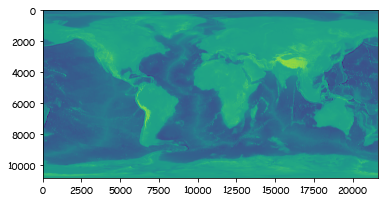

In [4]:

plt.imshow(image[0])
plt.show()

In [5]:
import geopandas as gpd
basins = gpd.read_file("../Nature/rivers/data/basins/samerica/hydrobasins_southam.shp")

In [6]:
import pandas as pd

colours_i_like = ['#A1CAF1',  '#875692', '#008856',  '#0067A5', '#BE0032',
                  '#222222', '#848482', '#F3C300',  'blue', '#F38400',
                  '#E68FAC', '#604E97', '#F3C300', '#B3446C', '#C2B280', 
                  '#F6A600', '#882D17', '#E25822', '#8DB600',
                  '#F99379',  '#DCD300', '#F3C300', '#E68FAC', '#C2B280',
                  '#222222']

colors_df = pd.DataFrame({'basin': basins.MAJ_NAME.unique().tolist(), 'colors': colours_i_like})

C:\Users\AdamS\anaconda3\envs\pythonmaps\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


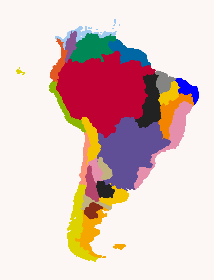

In [7]:
basins = pd.merge(basins, colors_df, left_on='MAJ_NAME', right_on='basin', how='left')

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
basins.plot(ax=ax, column='MAJ_NAME', edgecolor='face', color=basins['colors'])
ax.axis('off')
plt.tight_layout()
plt.savefig("outputs/basins.png", dpi=600, bbox_inches='tight')

In [8]:
from shapely.geometry import mapping
from rasterio import mask as msk 
import numpy as np

sa_array, clipped_transform = msk.mask(img, [mapping(geom) for geom in basins.geometry.tolist()], crop=True)
sa_array, clipped_transform = msk.mask(img, [mapping(geom) for geom in basins.geometry.tolist()], 
                                                      crop=True, nodata=(np.amin(sa_array[0]) - 1))

value_range = np.amax(sa_array) + abs(np.amin(sa_array))


In [9]:
from shapely.ops import unary_union

geoms = [unary_union(basins.loc[basins['MAJ_NAME'] == poly_basin].geometry.tolist()) for poly_basin in basins.MAJ_NAME.unique().tolist()]
geoms = [geom.boundary for geom in geoms]

In [10]:
print(geoms)

[<shapely.geometry.multilinestring.MultiLineString object at 0x0000020502252B50>, <shapely.geometry.multilinestring.MultiLineString object at 0x0000020502252880>, <shapely.geometry.multilinestring.MultiLineString object at 0x00000205022529A0>, <shapely.geometry.multilinestring.MultiLineString object at 0x0000020502252550>, <shapely.geometry.multilinestring.MultiLineString object at 0x00000205043771C0>, <shapely.geometry.multilinestring.MultiLineString object at 0x00000205043772B0>, <shapely.geometry.multilinestring.MultiLineString object at 0x0000020504377A90>, <shapely.geometry.linestring.LineString object at 0x0000020504377370>, <shapely.geometry.linestring.LineString object at 0x0000020504377310>, <shapely.geometry.linestring.LineString object at 0x0000020504377160>, <shapely.geometry.multilinestring.MultiLineString object at 0x0000020504377AC0>, <shapely.geometry.multilinestring.MultiLineString object at 0x0000020504377130>, <shapely.geometry.multilinestring.MultiLineString object 

In [11]:
new_basins = gpd.GeoDataFrame(pd.DataFrame({'Basin': basins.MAJ_NAME.unique().tolist()}), geometry=geoms)

<AxesSubplot:>

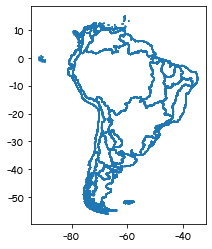

In [12]:
new_basins.plot()

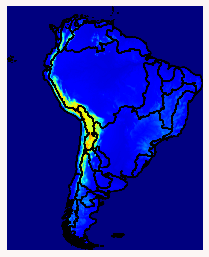

In [13]:
from rasterio.plot import show

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)

show(sa_array, ax=ax, transform=clipped_transform, cmap='jet')
new_basins.plot(ax=ax, edgecolor='black', lw=1)
ax.axis('off')

plt.savefig("test.png", dpi=1000, bbox_inches='tight')
plt.show()

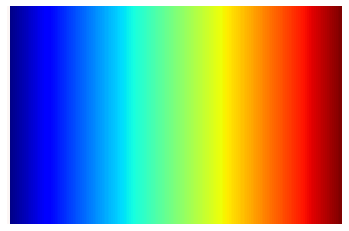

In [16]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib import cm
import numpy as np 
import matplotlib.colors
from matplotlib.colors import BoundaryNorm

our_cmap = cm.get_cmap('jet', int((value_range - 5300) / 10))
newcolors = our_cmap(np.linspace(0, 1, int((value_range - 5300) / 10)))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
our_cmap = ListedColormap(newcolors)

bounds = np.arange(np.amin(sa_array), np.amax(sa_array)-5300, 10)
norm = BoundaryNorm(bounds, our_cmap.N)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=our_cmap)
plt.axis('off')
plt.show()

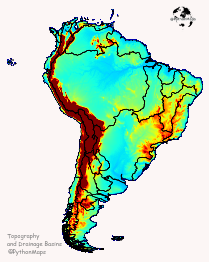

In [17]:
from rasterio.plot import show

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)

show(sa_array, ax=ax, transform=clipped_transform, cmap=our_cmap, norm=norm)
new_basins.plot(ax=ax, edgecolor='black', lw=0.5)
ax.axis('off')
newax = fig.add_axes([0.77, 0.65, 0.1, 0.1], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.0, 0.0, "Topography \nand Drainage Basins \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes)

plt.savefig("test.png", dpi=1000, bbox_inches='tight')
plt.show()